# The power-law lens

The power-law lens has a convergence profile of the kind
$$
\kappa(x)=\frac{3-n}{2}x^{1-n}
$$

The corresponding mass profile is 
$$
m(x)=x^{3-n}
$$
which implies that the deflection angle is 
$$
\alpha(x)=x^{2-n}
$$
and that the shear profile is
$$
\gamma(x)=\frac{m(x)}{x^2}-\kappa(x)=\frac{n-1}{2}x^{1-n} \;.
$$

Here are some plots of some of the relevant quantities.

In [128]:
from scipy.optimize import fsolve, newton

class pl_lens(object):
    def __init__(self,co,n=1.0,zl=0.5,zs=2.0,thetae=1.0):
        self.n=n
        self.thetae=thetae
        self.co=co
        
    def kappa(self,x):
        return((3.0-self.n)/2.0*np.abs(x)**(1.0-self.n))
    
    def gamma(self,x):
        return(np.abs((self.n-1.0)/2.0*np.abs(x)**(1.0-self.n)))
    
    def mass(self,x):
        return(np.abs(x)**(3.0-self.n))
    
    def alpha(self,x):
        return(np.sign(x)*np.abs(x)**(2.0-self.n))
    
    def lambdar(self,x):
        return 1-(2.0-self.n)*np.abs(x)**(1.0-self.n)

    def lambdat(self,x):
        return 1-np.abs(x)**(1.0-self.n)
    
    def radcl(self):
        return((2.0-self.n)**(1./(self.n-1)))

    def radcau(self):
        return -(self.radcl()-self.alpha(self.radcl()))

    def ext_source(self,yc1,yc2,rs):
        phi=np.linspace(0,2.*np.pi,1000)
        y1=yc1+rs*np.cos(phi)
        y2=yc2+rs*np.sin(phi)
        return(y1,y2,phi)
    
    def ext_images(self,yc1,yc2,rs):
        y1,y2,phi2=self.ext_source(yc1,yc2,rs)
        ys=np.sqrt(y1*y1+y2*y2)
        xi1=[]
        xi2=[]
        xi3=[]
        phi1=[]
        phi2=[]
        phi3=[]
        for j in range(len(ys)):
            def func(xx):
                return (xx-ys[j]-pl.alpha(xx))
            x0_ = fsolve(func,ys[j]+1.0)
            x1_ = fsolve(func,ys[j]-1.0)
            x3_ = fsolve(func,0.0)
            phi=np.arctan2(y2[j],y1[j])
            if (np.abs(func(x0_))<1e-8):
                xi1.append(x0_)
                phi1.append(phi)
            if (np.abs(func(x1_))<1e-8 and (np.sign(x1_) != np.sign(ys[j]))):
                xi2.append(x1_)
                phi2.append(phi)
            if (np.abs(func(x3_))<1e-8 and (np.sign(x1_) != np.sign(ys[j]))):
                xi3.append(x3_)
                phi3.append(phi)
        xi1=np.array(xi1).reshape(len(xi1))
        xi2=np.array(xi2).reshape(len(xi2))
        xi3=np.array(xi3).reshape(len(xi3))
        print (len(ys),xi1.shape)
        return(xi1,phi1,xi2,phi2,xi3,phi3)
    
    def pot_power(self,x):
        return 1.0/(3.0-self.n)*np.abs(x)**(3.0-self.n)

    def travel_time_power(self,y,x):
        return (0.5*(x-y)**2-self.pot_power(x))

    def time_delay(self,x1,x2):
        return(0.5*(x2**(2*(2.0-self.n))-x1**(2*(2-self.n)))-1.0/(3.0-self.n)*(x2**(3.0-self.n)-x1**(3.0-self.n))) 
    
    #utils
    def SigmaCrit(self):
        from astropy.constants import c, G
        dl=self.co.angular_diameter_distance(self.zl)
        ds=self.co.angular_diameter_distance(self.zs)
        dls=self.co.angular_diameter_distance_z1z2(self.zl,self.zs)
        c2_G_Msun_Mpc = (c**2/G).to(u.Msun/u.Mpc)
        sigma_cr = c2_G_Msun_Mpc/(4*np.pi)*(ds/dl/dls)
        return(sigma_cr)    

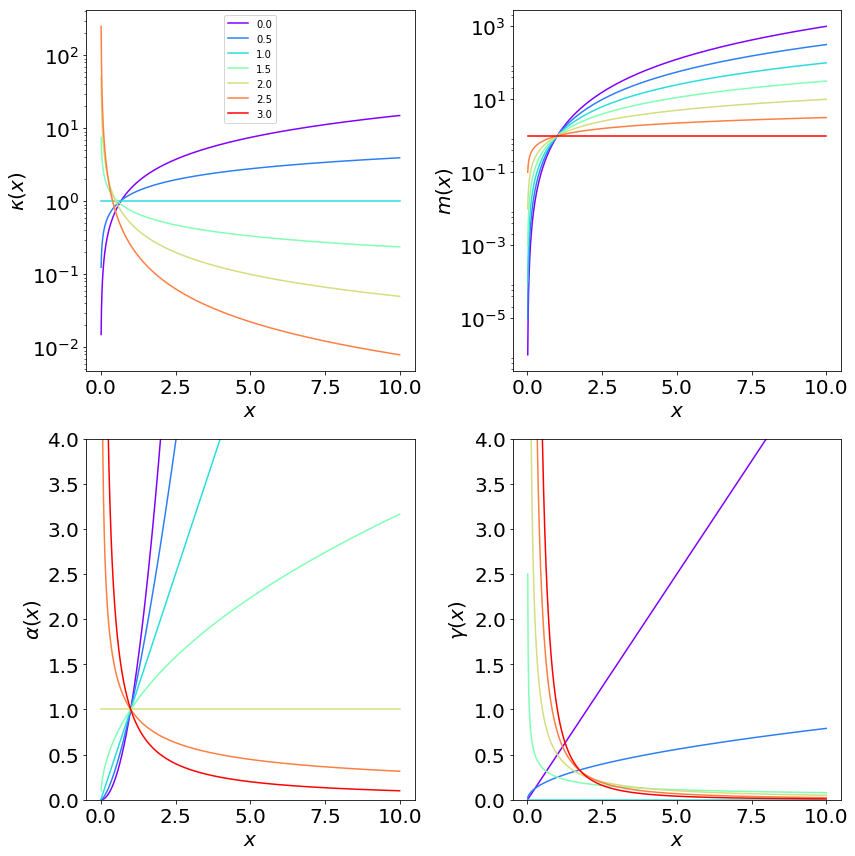

In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import cm 
from astropy.cosmology import FlatLambdaCDM
fig,ax=plt.subplots(2,2,figsize=(12,12))

x=np.logspace(-2,1.0,1000)
n=np.linspace(0,3,7)

color=iter(cm.rainbow(np.linspace(0,1,n.size)))
#ax[0,0].set_xscale('log')
ax[0,0].set_yscale('log')
#ax[0,1].set_xscale('log')
ax[0,1].set_yscale('log')
#ax[1,0].set_xscale('log')
##ax[1,0].set_yscale('log')
#ax[1,1].set_xscale('log')
##ax[1,1].set_yscale('log')
ax[1,0].set_ylim([0,4])
ax[1,1].set_ylim([0,4])

"""
When dealing with lenses at cosmological distances,
we need to specify a cosmological model
"""

co = FlatLambdaCDM(H0=70, Om0=0.3)

for i in range(n.size):
    pl=pl_lens(co,n=n[i],zl=0.5,zs=2.0,thetae=1.0)
    c=next(color)
    ka=pl.kappa(x)
    m=pl.mass(x)
    a=pl.alpha(x)
    g=pl.gamma(x)
    ax[0,0].plot(x,ka,color=c,label=str(n[i]))
    ax[0,1].plot(x,m,color=c,label=str(n[i]))
    ax[1,0].plot(x,a,color=c,label=str(n[i]))
    ax[1,1].plot(x,g,color=c,label=str(n[i]))
    
for i in range(2):
    for j in range(2):
        ax[i,j].xaxis.set_tick_params(labelsize=20)
        ax[i,j].yaxis.set_tick_params(labelsize=20)
    
ax[0,0].legend(loc='best')
ax[0,0].set_xlabel('$x$',fontsize=20)
ax[0,0].set_ylabel('$\kappa(x)$',fontsize=20)
ax[0,1].set_xlabel('$x$',fontsize=20)
ax[0,1].set_ylabel('$m(x)$',fontsize=20)
ax[1,0].set_xlabel('$x$',fontsize=20)
ax[1,0].set_ylabel(r'$\alpha(x)$',fontsize=20)
ax[1,1].set_xlabel('$x$',fontsize=20)
ax[1,1].set_ylabel(r'$\gamma(x)$',fontsize=20)

plt.tight_layout()

fig.savefig('power_law_props.png')


We can note that:
* for $n<1$, the power-law lens has a monotonically increasing convergence profile. Thus, this kind of lens models are not suited to describe the mass distribution of gravitationally bound systems like galaxies and galaxy clusters;
* for $n=1$, the convergence profile is flat (perfectly convergent lens);
* for $1 < n <2$, the convergence profile is a decreasing function of $x$ and $\alpha(x)$ is zero at origin; 
* for $n=2$, $\alpha(x)=const$, meaning that $\Psi(x)\propto x$ (the time delay surface becomes non-continuously deformable at $x=0$;
* for $2< n < 3$, $\alpha(x)$ diverges for $x\rightarrow 0$. The lensing potential is singular at the origin;
* the case $n=3$ corresponds to the point-mass lens: $m=1=const$, $\alpha(x)=1/x$;
* finally, $n>3$ is un-physical, since it produces mass profiles which decrease with $x$.


## Magnification and critical lines

The magnification is
$$
\det A=(1-\kappa-\gamma)(1-\kappa+\gamma)
$$

In particular, the inverse tangential and the radial magnifications are 
$$
\lambda_t=1-x^{1-n}
$$
and
$$
\lambda_r=1-(2-n)x^{1-n}
$$

The critical lines are given by
$$
x_t=1
$$
and 
$$
x_r=\left(\frac{1}{2-n}\right)^\frac{1}{1-n}=(2-n)^\frac{1}{n-1}
$$

This shows that the radial critical line exists for $1<n<2$.

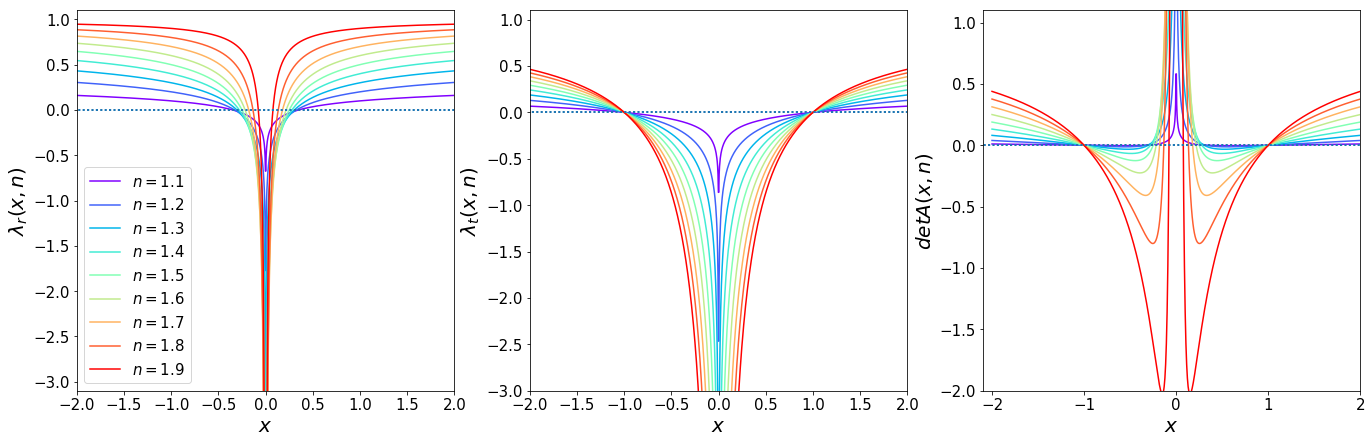

In [11]:
#n=np.linspace(.0,3.0,13)
n=np.linspace(1.1,1.9,9)
x=np.linspace(-2.0,2.0,1000)

fig,ax=plt.subplots(1,3,figsize=(23,7))
color=iter(cm.rainbow(np.linspace(0,1,n.size)))

for i in range(n.size):
    c=next(color)
    pl=pl_lens(co,n=n[i],zl=0.5,zs=2.0,thetae=1.0)
    ax[0].plot(x,pl.lambdar(x),color=c,label=r'$n=$'+str(n[i]))
    ax[1].plot(x,pl.lambdat(x),color=c)
    ax[2].plot(x,pl.lambdar(x)*pl.lambdat(x),color=c)

ax[0].set_xlabel(r'$x$',fontsize=20)
ax[1].set_xlabel(r'$x$',fontsize=20)
ax[2].set_xlabel(r'$x$',fontsize=20)
ax[0].set_ylabel(r'$\lambda_r(x,n)$',fontsize=20)
ax[1].set_ylabel(r'$\lambda_t(x,n)$',fontsize=20)
ax[2].set_ylabel(r'$detA(x,n)$',fontsize=20)
ax[0].legend(loc='best',fontsize=15)
ax[0].set_ylim([-3.1,1.1])
ax[1].set_ylim([-3,1.1])
ax[2].set_ylim([-2,1.1])
ax[0].set_xlim([-2,2])
ax[1].set_xlim([-2,2])
ax[2].set_xlim([-2.1,2])
for i in range(3):
    ax[i].xaxis.set_tick_params(labelsize=15)
    ax[i].yaxis.set_tick_params(labelsize=15)
    
x=[-3,3]
y=[0,0]
ax[0].plot(x,y,':',lw=2)
ax[1].plot(x,y,':',lw=2)
ax[2].plot(x,y,':',lw=2)
    
fig.savefig('powerlaw_lrlt.png')

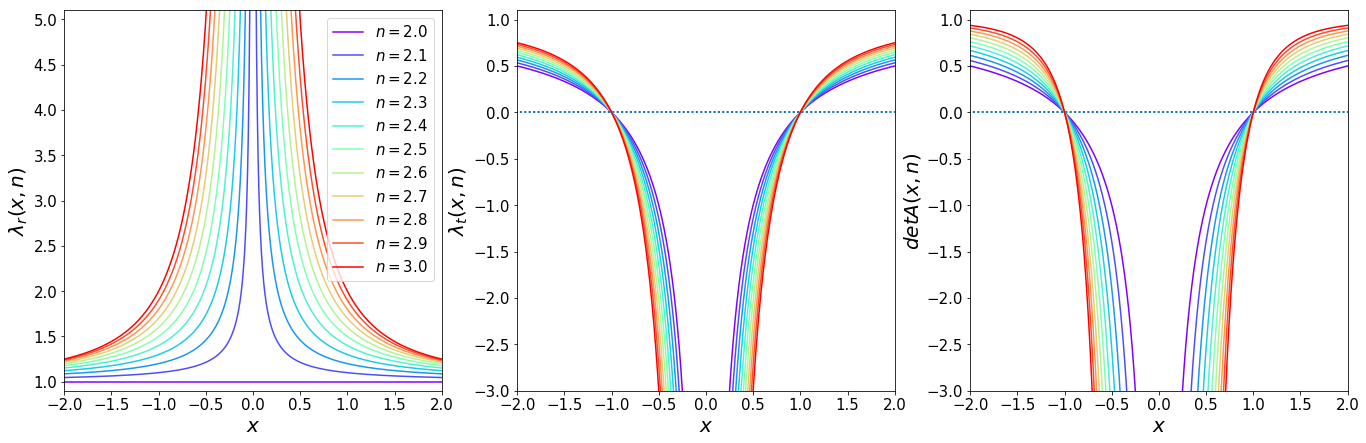

In [12]:
#n=np.linspace(.0,3.0,13)
n=np.linspace(2.0,3.0,11)
x=np.linspace(-2.0,2.0,1000)

fig,ax=plt.subplots(1,3,figsize=(23,7))
color=iter(cm.rainbow(np.linspace(0,1,n.size)))

for i in range(n.size):
    c=next(color)
    pl=pl_lens(co,n=n[i],zl=0.5,zs=2.0,thetae=1.0)
    ax[0].plot(x,pl.lambdar(x),color=c,label=r'$n=$'+str(n[i]))
    ax[1].plot(x,pl.lambdat(x),color=c)
    ax[2].plot(x,pl.lambdar(x)*pl.lambdat(x),color=c)


ax[0].set_xlabel(r'$x$',fontsize=20)
ax[1].set_xlabel(r'$x$',fontsize=20)
ax[2].set_xlabel(r'$x$',fontsize=20)
ax[0].set_ylabel(r'$\lambda_r(x,n)$',fontsize=20)
ax[1].set_ylabel(r'$\lambda_t(x,n)$',fontsize=20)
ax[2].set_ylabel(r'$detA(x,n)$',fontsize=20)
ax[0].legend(loc='best',fontsize=15)
ax[0].set_ylim([0.9,5.1])
ax[1].set_ylim([-3,1.1])
ax[2].set_ylim([-3,1.1])
ax[0].set_xlim([-2,2])
ax[1].set_xlim([-2,2])
ax[2].set_xlim([-2,2])
for i in range(3):
    ax[i].xaxis.set_tick_params(labelsize=15)
    ax[i].yaxis.set_tick_params(labelsize=15)
    
x=[-3,3]
y=[0,0]
ax[0].plot(x,y,':',lw=2)
ax[1].plot(x,y,':',lw=2)
ax[2].plot(x,y,':',lw=2)
    
fig.savefig('powerlaw_lrltn2.png')

/Users/massimo/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in double_scalars


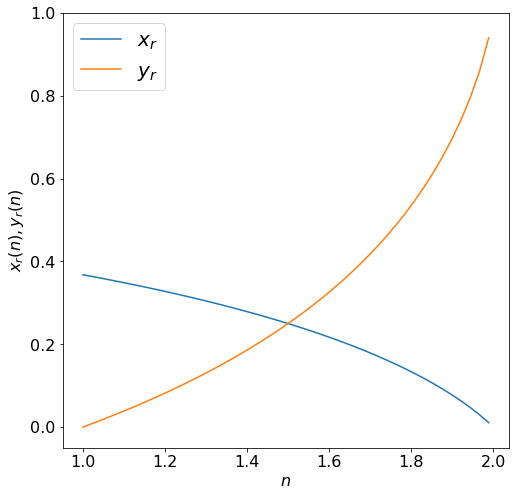

In [13]:
#n=np.linspace(0.0000001,3,90)
n=np.linspace(1.0001,3,90)

xr=[]
yr=[]

for n_ in n:
    pl=pl_lens(co,n=n_)
    xr.append(pl.radcl())
    yr.append(pl.radcau())
    
fig,ax=plt.subplots(1,1,figsize=(8,8))
ax.plot(n,xr,label=r'$x_r$')
ax.plot(n,yr,label=r'$y_r$')

ax.set_xlabel('$n$',fontsize=16)
ax.set_ylabel('$x_r(n),y_r(n)$',fontsize=16)
#ax.plot([1.0,1.0],[-1,1],':',color='black')
ax.set_ylim([-0.05,1.0])
ax.legend(loc='best',fontsize=20)

ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
fig.savefig('poweelaw_xrxt.png')

The radial critical line only exists if $n<2$. For $n>2$ there is no radial critical line.

# Multiple images

## Lenses with $n<2$

Let's discuss the occurrence of multiple images. To this goal, it is useful to build the so called "image diagram", comparing the two functions appearing in the lens equation, namely $\alpha(x)$ and $f(x)=x-y$.

The following figure shows the diagram for a power-law lens with $n=1.7$. The function $f(x)$ is shown for different values of $y$.

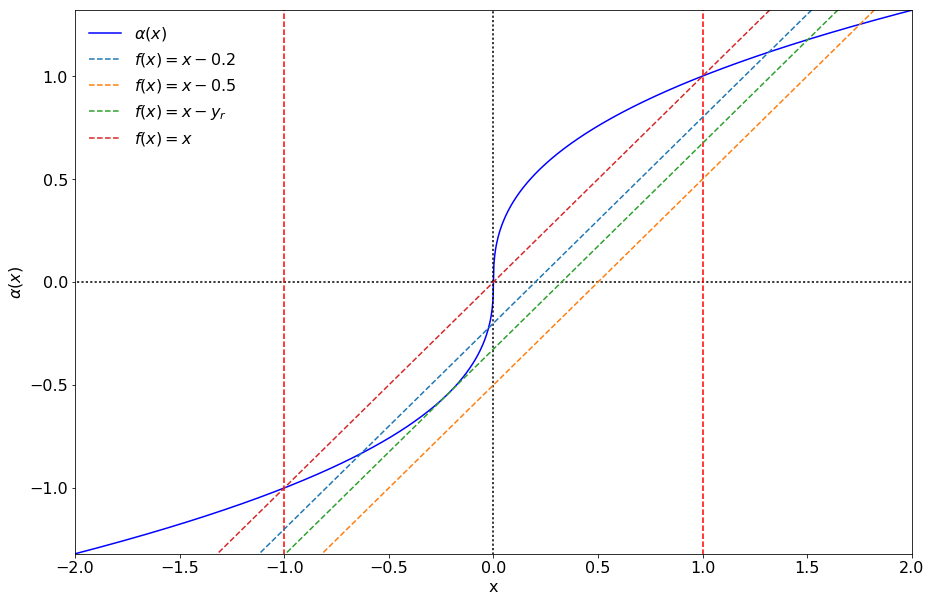

In [14]:
xmin=-2.0
xmax=-xmin
x=np.linspace(xmin,xmax,1000)
pl=pl_lens(co,n=1.6)
a=pl.alpha(x)

fig,ax=plt.subplots(1,1,figsize=(15,10))
ax.plot(x,a,'-',color='blue',label=r'$\alpha(x)$')
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_xlabel('x',fontsize=16)
ax.set_ylabel(r'$\alpha(x)$',fontsize=16)

xx=[xmin-0.2,xmax+0.2]
yy=[0,0]
ax.plot(xx,yy,':',color='black')
ax.plot(yy,xx,':',color='black')
ax.set_ylim(np.min(a),np.max(a))
ax.set_xlim(np.min(x),np.max(x))

ax.plot([-1,-1],xx,'--',color='red')
ax.set_ylim(np.min(a),np.max(a))
ax.set_xlim(np.min(x),np.max(x))

ax.plot([1,1],xx,'--',color='red')
ax.set_ylim(np.min(a),np.max(a))
ax.set_xlim(np.min(x),np.max(x))

ys=0.2
f=x-ys
ax.plot(x,f,'--',label=r'$f(x)=x-$'+str(ys))

ys=0.5
f=x-ys
ax.plot(x,f,'--',label=r'$f(x)=x-$'+str(ys))


ys=pl.radcau()
f=x-ys
ax.plot(x,f,'--',label=r'$f(x)=x-y_r$')

ys=0.0
f=x-ys
ax.plot(x,f,'--',label=r'$f(x)=x$')

ax.legend(fontsize=16,frameon=False)

The diagram clearly shows that the appearence of multiple images is tightly connected to the presence of a radial critical line. Indeed, there is maximum distance $y_r$ from the lens center projected onto the source plane, behind which the source won't produce multiple images. This maximum distance can be found by imposing a tangency condition between $\alpha(x)$ and $f(x)$. Since the slope of $f(x)$ is one. This condition writes:

$$
\frac{d\alpha}{dx}=1
$$

which indeed defines the radial critical line. Thus, $y_r$ is the radius of the radial caustic.

The following are some image diagrams for lenses with $n=1.1,1.0,1.5$

/Users/massimo/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/massimo/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/Users/massimo/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


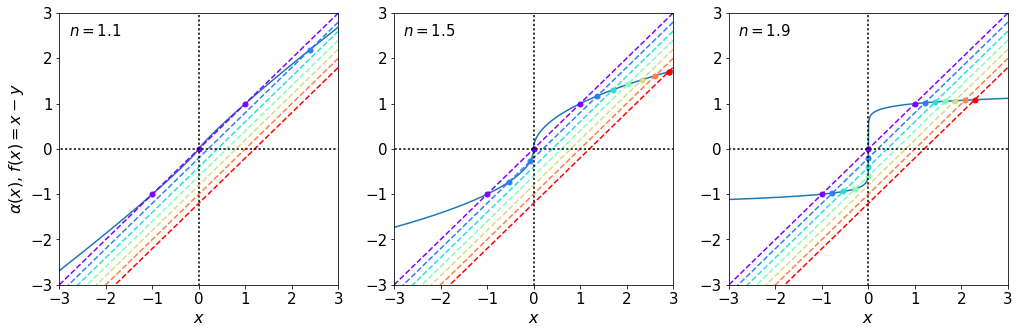

In [16]:
import math
from scipy.optimize import *

n=[1.1,1.5,1.9]

fig,ax=plt.subplots(1,3,figsize=(17,5))

x=np.linspace(-3,3,1000)

def f(x,y):
    return(x-y)
    
ys=np.linspace(0,1.2,7)


    
for i in range(len(n)):
    pl=pl_lens(co,n=n[i])
    a=pl.alpha(x)
    ax[i].plot(x,a,'-')
    color=iter(cm.rainbow(np.linspace(0,1,len(ys))))
    for j in range(len(ys)):
        c=next(color)
        fu=f(x,ys[j])
        ax[i].plot(x,fu,'--',c=c)
        def func(xx):
            return f(xx,ys[j])-pl.alpha(xx)
        x0 = fsolve(func,1.0)
        x1 = fsolve(func,-1.0)
        x3 = fsolve(func,0.0)
        if (np.abs(func(x0))<1e-8):
            ax[i].plot(x0,pl.alpha(x0),'o',markersize=5,c=c)
        if (np.abs(func(x1))<1e-8):
            ax[i].plot(x1,pl.alpha(x1),'o',markersize=5,c=c)
        if (np.abs(func(x3))<1e-8):
            ax[i].plot(x3,pl.alpha(x3),'o',markersize=5,c=c)
        
        
    ax[i].set_xlim([-3,3])
    ax[i].set_ylim([-3,3])
    ax[i].text(-2.8,2.5,'$n=$'+str(n[i]),fontsize=15)

    
    xa=[0.0,0.0]
    ya=[-10,10]
    ax[i].plot(xa,ya,':',color='black')
    
    xa=[-10.0,10.0]
    ya=[0,0]
    ax[i].plot(xa,ya,':',color='black')
    
    ax[0].set_ylabel(r'$\alpha(x)$, $f(x)=x-y$',fontsize=16)
    ax[0].legend()
    for i in range(3):
        ax[i].xaxis.set_tick_params(labelsize=15)
        ax[i].yaxis.set_tick_params(labelsize=15)
        ax[i].set_xlabel('$x$',fontsize=16)
    fig.savefig('powelaw_imagediag.png')



Some noticeable properties:
* these lenses produce three or one image
* three images are formed if the source lays inside the radial critical line, i.e. for $y<y_r$, where $y_r$ corresponds to $x_r: dy/dx=0$

/Users/massimo/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/massimo/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


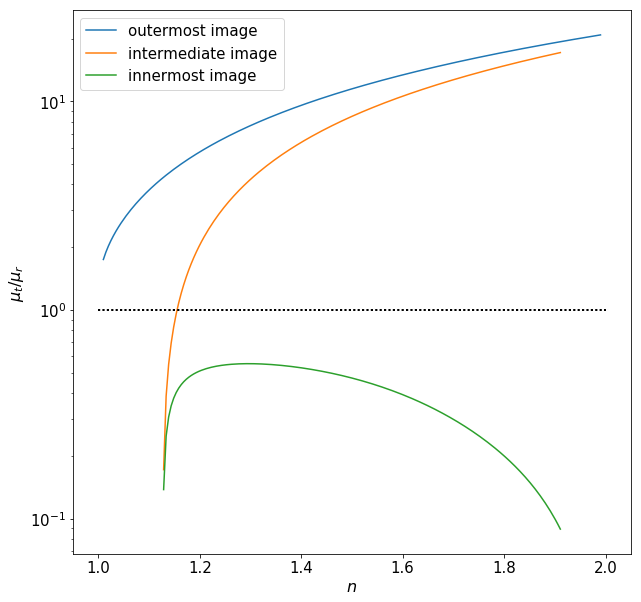

In [17]:
n=np.linspace(1.01,1.99,199)
ys=0.05
mr_1=[]
mr_2=[]
mr_3=[]
n1=[]
n2=[]
n3=[]
x=np.linspace(-3,3,100000)

def f(x,y):
    return(x-y)

for i in range(len(n)):
    pl=pl_lens(co,n=n[i])
    a=pl.alpha(x)
    fu=f(x,ys)
    def func(xx):
        return f(xx,ys)-pl.alpha(xx)
    x0 = fsolve(func,1.0)
    x1 = fsolve(func,-1.0)
    x3 = fsolve(func,0.0)
    if (np.abs(func(x0))<1e-6):
        mr_1.append(pl.lambdar(x0)/pl.lambdat(x0))
        n1.append(n[i])
    if (np.abs(func(x3))<1e-6):
        mr_2.append(pl.lambdar(x1)/pl.lambdat(x1))
        n2.append(n[i])
    if (np.abs(func(x3))<1e-6):
        mr_3.append(pl.lambdar(x3)/pl.lambdat(x3))
        n3.append(n[i])

fig,ax=plt.subplots(1,1,figsize=(10,10))
ax.plot(n1,np.abs(mr_1),'-',label='outermost image')
ax.plot(n2,np.abs(mr_2),'-',label='intermediate image')
ax.plot(n3,np.abs(mr_3),'-',label='innermost image')
ax.set_yscale('log')
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_xlabel('$n$',fontsize=16)
ax.set_ylabel(r'$\mu_t/\mu_r$',fontsize=16)
xx=[1,2]
yy=[1,1]
ax.plot(xx,yy,":",lw=2,color='black')
ax.legend(fontsize=15)
fig.savefig('powerlens_muratio_ysfixed.png')

The result above can be visually confirmed by using the code below, which solves the lens equation for all points on the boundary of a circular extended source:

1000 (1000,)


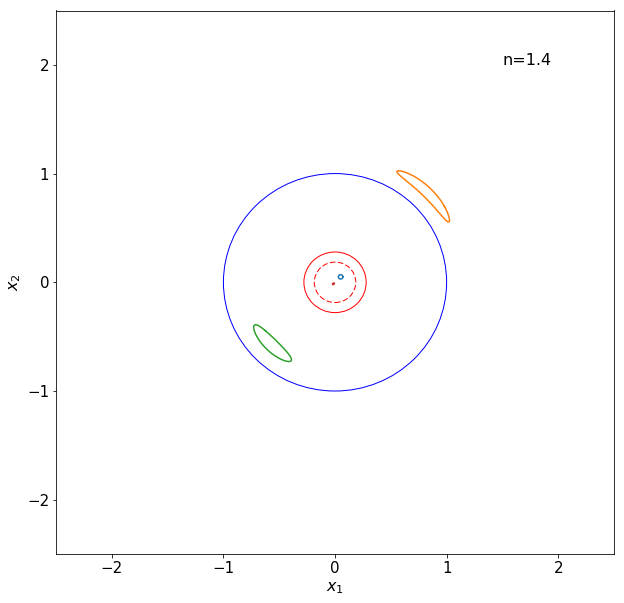

In [133]:
nl=1.4
pl=pl_lens(co,n=nl)
yc1=0.05
yc2=0.05
rs=0.02
ys1,ys2,phi=pl.ext_source(yc1,yc2,rs)
xi1,phi1,xi2,phi2,xi3,phi3=pl.ext_images(yc1,yc2,rs)


fig,ax=plt.subplots(1,1,figsize=(10,10))

er=plt.Circle((0,0),1.0,color='blue',fill=False)
rad_cl=plt.Circle((0,0),pl.radcl(),color='red',fill=False)
rad_cau=plt.Circle((0,0),pl.radcau(),ls='--',color='red',fill=False)
ax.add_artist(er)
ax.add_artist(rad_cl)
ax.add_artist(rad_cau)

ax.plot(ys1,ys2,'-')
x1=np.array(xi1)*np.cos(phi1)
x2=np.array(xi1)*np.sin(phi1)
ax.plot(x1,x2,'-')
if (xi2.size>0):
    x1=np.array(xi2)*np.cos(phi2)
    x2=np.array(xi2)*np.sin(phi2)
    ax.plot(x1,x2,'-')
if (xi3.size>0):
    x1=np.array(xi3)*np.cos(phi3)
    x2=np.array(xi3)*np.sin(phi3)
    ax.plot(x1,x2,'-')
ax.set_xlim([-2.5,2.5])
ax.set_ylim([-2.5,2.5])

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_xlabel(r'$x_1$',fontsize=16)
ax.set_ylabel(r'$x_2$',fontsize=16)
ax.text(1.5,2,'n='+str(nl),fontsize=16)

/Users/massimo/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/Users/massimo/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


1000 (1000,)
1000 (1000,)
1000 (1000,)
1000 (1000,)


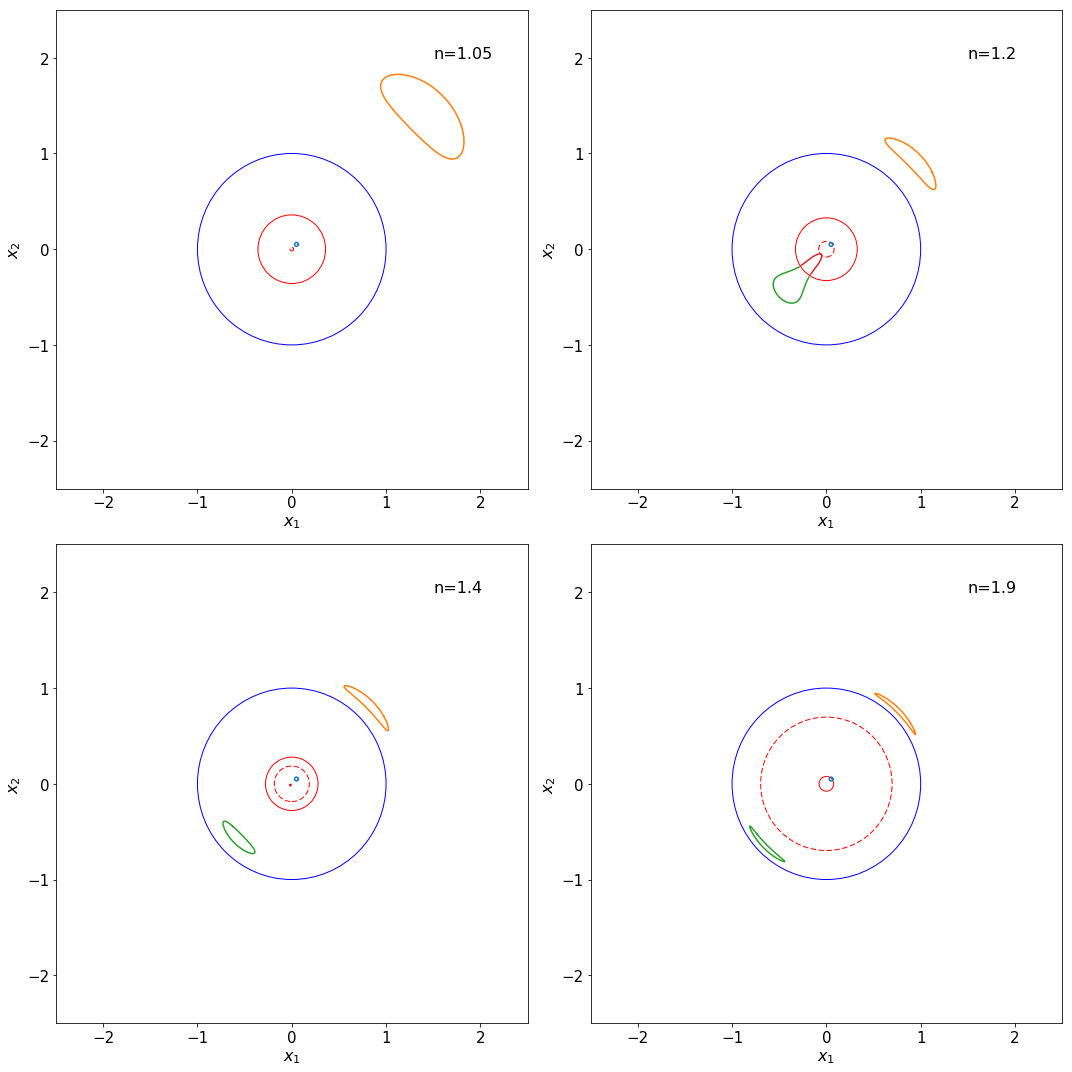

In [147]:
nl=[1.05,1.2,1.4,1.9]
px=[0,0,1,1]
py=[0,1,0,1]
yc1=0.03535
yc2=0.03535
rs=0.02
fig,ax=plt.subplots(2,2,figsize=(15,15))
for i in range(len(nl)):
    pl=pl_lens(co,n=nl[i])
    yc1=0.05
    yc2=0.05
    ys1,ys2,phi=pl.ext_source(yc1,yc2,rs)
    xi1,phi1,xi2,phi2,xi3,phi3=pl.ext_images(yc1,yc2,rs)

    er=plt.Circle((0,0),1.0,color='blue',fill=False)
    rad_cl=plt.Circle((0,0),pl.radcl(),color='red',fill=False)
    rad_cau=plt.Circle((0,0),pl.radcau(),ls='--',color='red',fill=False)
    ax[px[i],py[i]].add_artist(er)
    ax[px[i],py[i]].add_artist(rad_cl)
    ax[px[i],py[i]].add_artist(rad_cau)

    ax[px[i],py[i]].plot(ys1,ys2,'-')
    x1=np.array(xi1)*np.cos(phi1)
    x2=np.array(xi1)*np.sin(phi1)
    ax[px[i],py[i]].plot(x1,x2,'-')
    if (xi2.size>0):
        x1=np.array(xi2)*np.cos(phi2)
        x2=np.array(xi2)*np.sin(phi2)
        ax[px[i],py[i]].plot(x1,x2,'-')
    if (xi3.size>0):
        x1=np.array(xi3)*np.cos(phi3)
        x2=np.array(xi3)*np.sin(phi3)
        ax[px[i],py[i]].plot(x1,x2,'-')
    ax[px[i],py[i]].set_xlim([-2.5,2.5])
    ax[px[i],py[i]].set_ylim([-2.5,2.5])

    ax[px[i],py[i]].xaxis.set_tick_params(labelsize=15)
    ax[px[i],py[i]].yaxis.set_tick_params(labelsize=15)
    ax[px[i],py[i]].set_xlabel(r'$x_1$',fontsize=16)
    ax[px[i],py[i]].set_ylabel(r'$x_2$',fontsize=16)
    ax[px[i],py[i]].text(1.5,2,'n='+str(nl[i]),fontsize=16)
    
plt.tight_layout()
fig.savefig('power_law_examples.png')

# Lenses with $n>2$

These lenses always produce multiple images because of the singuarity of their lensing potential.

The following are some examples of image diagrams for $n=2.0,2.1,3.0$.

/Users/massimo/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/massimo/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/Users/massimo/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/Users/massimo/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in power
/Users/massimo/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in multiply
/Users/massimo/anaconda/lib/py

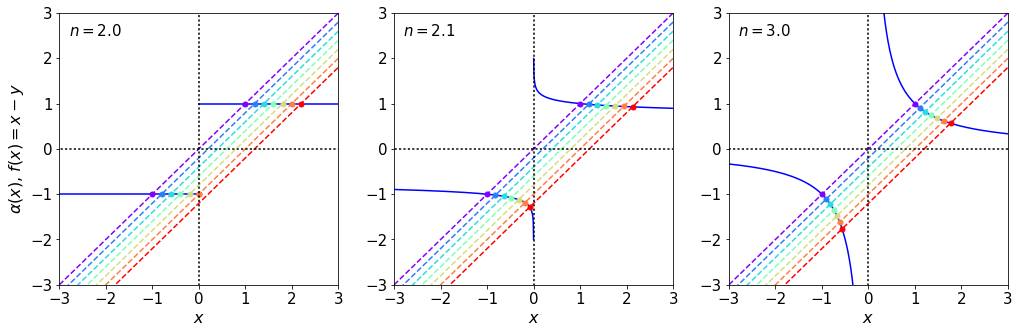

In [18]:
n=[2.0,2.1,3.0]

fig,ax=plt.subplots(1,3,figsize=(17,5))

x0=np.linspace(-3,-1.e-3,500)
x1=np.linspace(1.e-3,3,500)
    
ys=np.linspace(0,1.2,7)
    
for i in range(len(n)):
    pl=pl_lens(co,n=n[i])
    a0=pl.alpha(x0)
    a1=pl.alpha(x1)
    ax[i].plot(x0,a0,'-',color='blue')
    ax[i].plot(x1,a1,'-',color='blue')
    color=iter(cm.rainbow(np.linspace(0,1,len(ys))))
    for j in range(len(ys)):
        c=next(color)
        fu=f(x,ys[j])
        ax[i].plot(x,fu,'--',c=c)
        def func(xx):
            return f(xx,ys[j])-pl.alpha(xx)
        x0_ = fsolve(func,1.0)
        x1_ = fsolve(func,-1.0)
        x3_ = fsolve(func,0.0)
        if (np.abs(func(x0_))<1e-8):
            ax[i].plot(x0_,pl.alpha(x0_),'o',markersize=5,c=c)
        if (np.abs(func(x1_))<1e-8):
            ax[i].plot(x1_,pl.alpha(x1_),'o',markersize=5,c=c)
        if (np.abs(func(x3_))<1e-8 and j>0):
            ax[i].plot(x3_,pl.alpha(x3_),'o',markersize=5,c=c)
            
    ax[i].set_xlim([-3,3])
    ax[i].set_ylim([-3,3])
    ax[i].text(-2.8,2.5,'$n=$'+str(n[i]),fontsize=15)

    xa=[0.0,0.0]
    ya=[-10,10]
    ax[i].plot(xa,ya,':',color='black')
    
    xa=[-10.0,10.0]
    ya=[0,0]
    ax[i].plot(xa,ya,':',color='black')
    
    ax[0].set_ylabel(r'$\alpha(x)$, $f(x)=x-y$',fontsize=16)
    ax[0].legend()
    for i in range(3):
        ax[i].xaxis.set_tick_params(labelsize=15)
        ax[i].yaxis.set_tick_params(labelsize=15)
        ax[i].set_xlabel('$x$',fontsize=16)
    fig.savefig('powelaw_imagediagn2.png')



Notice  that
* none of these lenses ever has a central image
* while for a lens with $n=2$ produces multiple images only for $|y|<y_{cut}=1$, all lenses with $n>2$ always have 2 images
* the $x_{-}$ image always moves towards the center of the lens as $y\rightarrow \infty$

# Image separation vs $n$

We explore now the sensitivity of image separation on the power-law index $n$.

/Users/massimo/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/massimo/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/Users/massimo/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in power
/Users/massimo/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in multiply


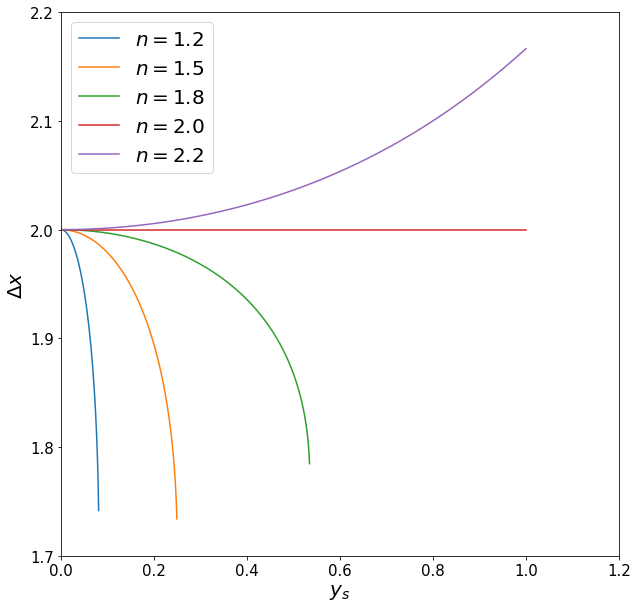

In [78]:
n=[1.2,1.5,1.8,2.0,2.2]

x0=np.linspace(-3,-1.e-3,500)
x1=np.linspace(1.e-3,3,500)
    
ys=np.linspace(0,1,1000)

fig,ax=plt.subplots(1,1,figsize=(10,10))
    
for i in range(len(n)):
    pl=pl_lens(co,n=n[i])
    a0=pl.alpha(x0)
    a1=pl.alpha(x1)
    s0=np.zeros(ys.size)
    s1=np.zeros(ys.size)
    s2=np.zeros(ys.size)
    dtheta=[]
    ytheta=[]
    te=[]
    for j in range(len(ys)):
        def func(xx):
            return f(xx,ys[j])-pl.alpha(xx)
        x0_ = fsolve(func,1.0)
        x1_ = fsolve(func,-1.0)
        x2_ = fsolve(func,0.0)
        if (np.abs(func(x0_))<1e-8):
            s0[j]=x0_[0]
        if (np.abs(func(x1_))<1e-8 and x1_<0):
            s1[j]=x1_[0]
            dtheta.append(np.abs(s1[j]-s0[j]))
            ytheta.append(ys[j])
        if (np.abs(func(x2_))<1e-8):
            s2[j]=x2_[0]
    
    ax.set_xlim([0,1.2])
    ax.plot(ytheta,dtheta,'-',label='$n=$'+str(n[i]))
    ax.legend(loc='best',fontsize=20)
    ax.set_xlabel('$y_s$',fontsize=20)
    ax.set_ylabel('$\Delta x$',fontsize=20)
    ax.set_ylim([1.7,2.2])
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)




# Time delays

The formula for the light travel time is 
$$
t(x)=\frac{(1+z_L)}{c}\frac{D_{L}D_S}{D_{LS}}\frac{\xi_0^2}{D_L^2}\left[\frac{1}{2}(x-y)^2-\psi(x)\right]=\frac{(1+z_L)}{c}\frac{D_{L}D_S}{D_{LS}}\tau(x)
$$

For a power-law lens, the lensing potential is
$$
\psi(x)=\frac{1}{3-n}x^{3-n}
$$
so that
$$
\tau(x)=\frac{\xi_0^2}{D_L^2}\left[\frac{1}{2}(x-y)^2-\frac{1}{3-n}x^{3-n}\right]
$$

At the image positions
$$
x-y=\alpha(x)=x^{2-n}
$$
thus
$$
\tau(x_i)=\frac{\xi_0^2}{D_L^2}\left[\frac{1}{2}x_i^{2(2-n)}-\frac{1}{3-n}x_i^{3-n}\right]
$$

We can then compute the time delay between the images:
$$
\Delta t_{ij} \propto \Delta \tau_{ij}=\frac{\xi_0^2}{D_L^2}\left[\frac{1}{2}\left(x_j^{2(2-n)}-x_i^{2(2-n)}\right)-\frac{1}{3-n}\left(x_j^{3-n}-x_i^{3-n}\right)\right]
$$
For $n=2$, this formula gives:
$$
\Delta \tau_{ij}=\frac{\xi_0^2}{D_L^2}(x_i-x_j)=\theta_E^2\left(\frac{\theta_i}{\theta_E}-\frac{\theta_j}{\theta_E}\right)=\frac{1}{2}\left(\theta_i^2-\theta_j^2\right)=\Delta\tau_{SIS}
$$



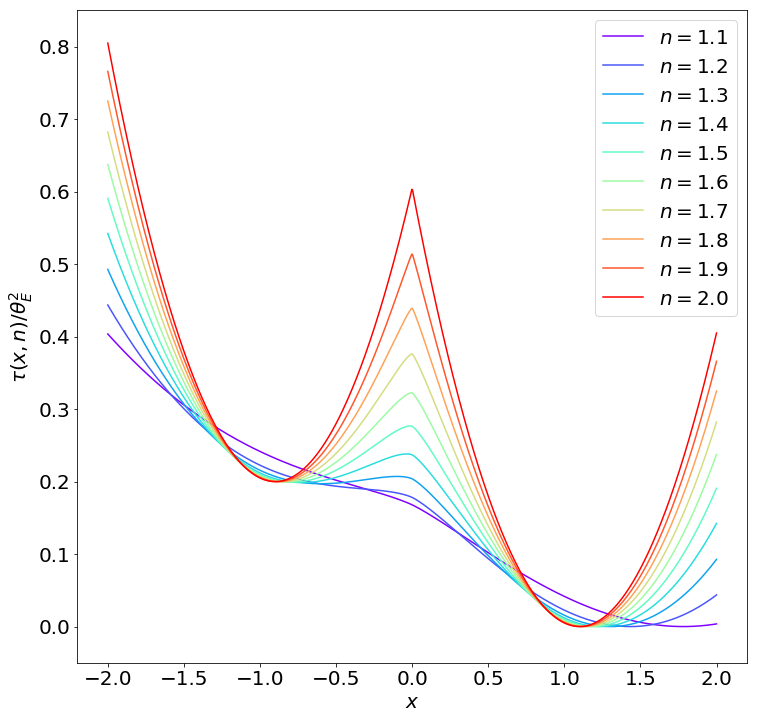

In [127]:
x=np.linspace(-2.0,2.0)
n=np.linspace(1.1,2.0,10)

color=iter(cm.rainbow(np.linspace(0,1,n.size)))

x=np.linspace(-2.0,2.0,1000)

fig,ax=plt.subplots(1,1,figsize=(12,12))

y=0.1
for i in range(n.size):
    pl=pl_lens(co,n=n[i])
    c=next(color)
    ax.plot(x,pl.travel_time_power(y,x)-np.amin(pl.travel_time_power(y,x)),color=c,label=r'$n=$'+str(n[i]))
    #ax.plot(x,pot_power(x,n[i]),color=c)
ax.set_xlabel('$x$',fontsize=20)
ax.set_ylabel(r'$\tau(x,n)/\theta_E^2$',fontsize=20)
ax.legend(loc='best',fontsize=20)
ax.set_ylim([-0.05,0.85])
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
fig.savefig('powerlaw_timedelay.png')

/Users/massimo/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/massimo/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


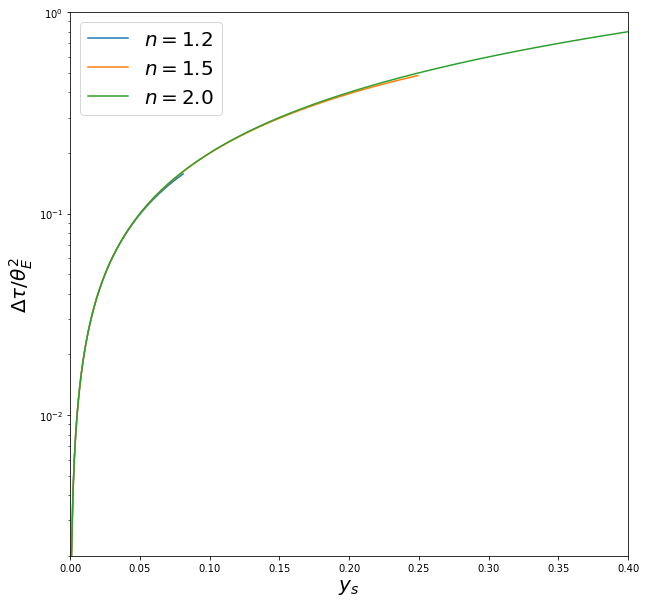

In [129]:
n=[1.2,1.5,2.0]

x0=np.linspace(-3,-1.e-3,500)
x1=np.linspace(1.e-3,3,500)
    
ys=np.linspace(0,1,1000)

fig,ax=plt.subplots(1,1,figsize=(10,10))

    
for i in range(len(n)):
    pl=pl_lens(co,n=n[i])
    a0=pl.alpha(x0)
    a1=pl.alpha(x1)
    s0=np.zeros(ys.size)
    s1=np.zeros(ys.size)
    ytheta=[]
    td=[]
    dtheta=[]
    for j in range(len(ys)):
        def func(xx):
            return f(xx,ys[j])-pl.alpha(xx)
        x0_ = fsolve(func,1.0)
        x1_ = fsolve(func,-1.0)
        if (np.abs(func(x0_))<1e-8):
            s0[j]=x0_[0]
        if (np.abs(func(x1_))<1e-8 and x1_<0):
            s1[j]=x1_[0]
            dtheta.append(s1[j]+s0[j])
            ytheta.append(ys[j])
            t=pl.time_delay(s0[j],-s1[j])
            td.append(t)
    
    ax.set_xlim([0,0.4])
    ax.set_ylim([0,1.0])
    ax.set_yscale('log')
    ax.plot(ytheta,td,'-',label='$n=$'+str(n[i]))
    ax.legend(loc='best',fontsize=20)
    ax.set_xlabel('$y_s$',fontsize=20)
    ax.set_ylabel(r'$\Delta \tau/\theta_E^2$',fontsize=20)

In the case of small image separations with respect to the size of the Einstein radius (i.e. $y<<1$), Kochanek (2002) derived an approximated formula stating that
$$
\Delta t(n)=(n-1)\Delta t_{SIS}\left[1-\frac{(2-n)^2}{12}\left(\frac{\delta\theta}{\langle\theta\rangle}\right)^2+...\right]
$$
The formula however works also in the case of $\delta\theta/\langle\theta\rangle$ of order unity.

Let us assume to observe an image separation of $\delta\theta=1"$ and $\langle\theta\rangle=5"$. In this case $\Delta t(n)/\Delta t_{SIS}$ looks like this:

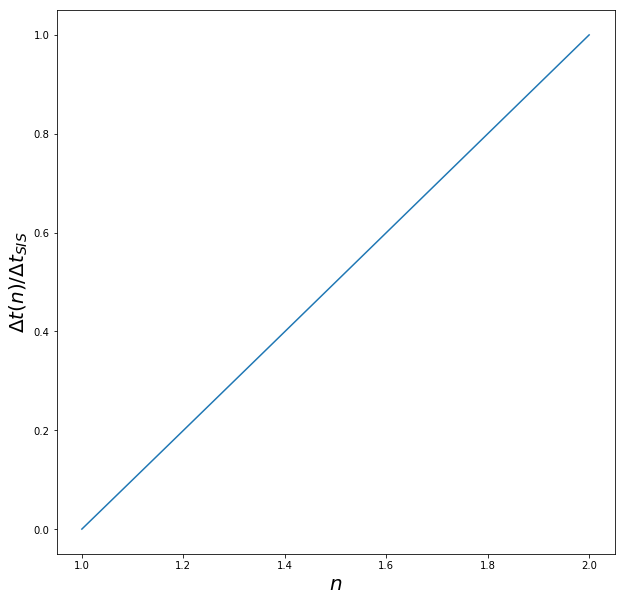

In [130]:
def deltat(dtheta,thetam,n):
    return (n-1)*(1-(2-n)**2/12*dtheta**2/thetam**2)

n=np.linspace(1.0,2.0,100)
dt=deltat(1.0,5.0,n)

fig,ax=plt.subplots(1,1,figsize=(10,10))

ax.plot(n,dt,'-')
ax.set_xlabel('$n$',fontsize=20)
ax.set_ylabel(r'$\Delta t(n)/\Delta t_{SIS}$',fontsize=20)

This shows that more centrally concentrated lenses (larger $n$) produce larger time delays for a fixed image separation.